# SI 618 Homework 5 - Natural Language Processing

### The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, punctuation, etc. of written sentences.
- 10 pt: Code is written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. Questions 1 through 6 are worth 10 points each; Question 7 is worth 20 points.

Version 2022.02.22.2.CT

## Background

(From https://www.kaggle.com/headsortails/us-election-2020-presidential-debates.)

The US 2020 election saw the incumbent Republican president Donald Trump facing off against his Democrat challenger Joe Biden. Both candidates agreed to debate their political stances in the lead-up to the vote on November 3rd.

The 1st debate took place on September 29th at Case Western Reserve University in Cleveland, Ohio. It was moderated by Fox News anchor Chris Wallace. 

After Donald Trump tested positive for Covid-19 after his first debate and subsequently recovered, the 2nd presidential debate was initially converted into a virtual event. However, Trump declined to participate in a virtual debate and the event was transformed into a (socially distanced) town hall with Joe Biden alone. This event was moderated by George Stephanopoulos on the ABC network and took place on October 15th. Donald Trump then decided to hold a town hall of his own, which took place at the same day and time as the Biden town hall and was aired on NBC. This event was moderated by Savannah Guthrie.

The actual 2nd, and final, presidential debate between Biden and Trump took place on October 22nd at Belmont University, Nashville, Tennessee and was moderated by NBC News' Kristen Welker. This debate implemented stricter conditions on the candidates' speaking times to limit the frequent interruptions that had characterised the 1st debate.

The goal of this homework assignment is to investigate the transcripts of those events.

The data files are available via https://github.com/umsi-data-science/data/tree/main/us_election_2020.  Note that each file is available in two formats: CSV and TXT. You can work from either format -- the content of the corresponding CSV and TXT files is the same.

You can either use the correct URLs to the Raw version of the data files like we've done with other data files in the course so far, you can clone the repo if you're comfortable with ```git```, or you can click on each file and then view the "Raw" format and download the resulting file.  You do not need the us_election_2020_vice_presidential_debate files as we are only concerned with the presidential debates and town halls for this assignment.

Note that *you* will need to make decisions about how you
proceed with the analysis.  For example, you will need to 
decide whether you include or omit stopwords, whether you stem or lemmatize words before analysis, and how you handle weird situations.

You will need to decide when to exclude speech from the moderators and when to include it (note that in most cases, the assignment asks about the candidates, which means Trump and Biden and not the moderators).

Please fill in your uniqname in the next code cell:

In [1]:
MY_UNIQNAME = "yjwoo"

Answer each of the questions below.  You are encouraged to use as many code and markdown cells as you need for each question.

We **strongly** suggest running all cells from top to bottom before you submit your notebook.

In [740]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import PorterStemmer
import matplotlib.patches as mpatches
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from spacy.tokens import Doc
import statsmodels.api as sm
import statsmodels.formula.api as smf

## 1. How many words did each candidate (Trump & Biden) use in each debate?

### 1-0. prepare the data for each candidate

In [683]:
txt_1st = pd.read_csv("./data/us_election_2020_1st_presidential_debate.csv")
txt_2nd = pd.read_csv("./data/us_election_2020_2nd_presidential_debate.csv")
txt_townhall_biden = pd.read_csv("./data/us_election_2020_biden_town_hall.csv")
txt_townhall_trump = pd.read_csv("./data/us_election_2020_trump_town_hall.csv")

Let's find all rows spoken by Trump and Biden, and make two data frames, one for only Trump and the other for only Biden.

#### Data for Biden

In [684]:
txt_1st.speaker.unique()

array(['Chris Wallace', 'Vice President Joe Biden',
       'President Donald J. Trump', 'Chris Wallace:'], dtype=object)

In [685]:
txt_1st_biden = txt_1st[txt_1st.speaker == "Vice President Joe Biden"][["text"]]
txt_1st_biden["source"] = "1st_debate"

In [686]:
txt_2nd.speaker.unique()

array(['Kristen Welker', 'Donald Trump', 'Joe Biden'], dtype=object)

In [687]:
txt_2nd_biden = txt_2nd[txt_2nd.speaker == "Joe Biden"][["text"]]
txt_2nd_biden["source"] = "2nd_debate"

In [688]:
txt_townhall_biden.speaker.unique()

array(['George Stephanopoulos', 'Joe Biden', 'Nicholas Fed', 'Kelly Lee',
       'Anthony Archer', 'Voice Over', 'Cedric Humphrey',
       'George Stephanopoulus', 'Angelia Politarhos', 'Speaker 1',
       'Nathan Osburn', 'Andrew Lewis', 'Speaker 2', 'Michele Ellison',
       'Mark Hoffman', 'Mieke Haeck', 'Speaker 3', 'Keenan Wilson'],
      dtype=object)

In [689]:
txt_townhall_biden_only = txt_townhall_biden[txt_townhall_biden.speaker == "Joe Biden"][["text"]]
txt_townhall_biden_only["source"] = "townhall"

In [690]:
txt_biden = pd.concat([txt_1st_biden, txt_2nd_biden, txt_townhall_biden_only])

In [691]:
txt_biden

,text,source
2,"How you doing, man?",1st_debate
4,I’m well.,1st_debate
9,"Well, first of all, thank you for doing this a...",1st_debate
11,The American people have a right to have a say...,1st_debate
12,"Now, what’s at stake here is the President’s m...",1st_debate
...,...,...
212,"Every single solitary generation, the dial has...",townhall
214,We’d better be able to do it again.,townhall
216,"Well, it could say I’m a lousy candidate, and ...",townhall
218,"Yeah. And by the way, before I came up here, I...",townhall


#### Data for Trump

In [692]:
txt_1st.speaker.unique()

array(['Chris Wallace', 'Vice President Joe Biden',
       'President Donald J. Trump', 'Chris Wallace:'], dtype=object)

In [693]:
txt_1st_trump = txt_1st[txt_1st.speaker == "President Donald J. Trump"][["text"]]
txt_1st_trump["source"] = "1st_debate"

In [694]:
txt_2nd.speaker.unique()

array(['Kristen Welker', 'Donald Trump', 'Joe Biden'], dtype=object)

In [695]:
txt_2nd_trump = txt_2nd[txt_2nd.speaker == "Donald Trump"][["text"]]
txt_2nd_trump["source"] = "2nd_debate"

In [696]:
txt_townhall_trump.speaker.unique()

array(['Savannah Guthrie', 'Speaker 1', 'President Trump',
       'Jacqueline Lugo', 'Barbara Peña', 'Isabella Peña', 'Savannah',
       'Cristy Montesinos Alonso', 'Adam Schucher', 'Moriah Geene',
       'Cindy Velez', 'Paulette Dale'], dtype=object)

In [697]:
txt_townhall_trump_only = txt_townhall_trump[txt_townhall_trump.speaker == "President Trump"][["text"]]
txt_townhall_trump_only["source"] = "townhall"

In [698]:
txt_trump = pd.concat([txt_1st_trump, txt_2nd_trump, txt_townhall_trump_only])

In [699]:
txt_trump

,text,source
3,How are you doing?,1st_debate
6,"Thank you very much, Chris. I will tell you ve...",1st_debate
7,And we won the election and therefore we have ...,1st_debate
10,"Thank you, Joe.",1st_debate
14,There aren’t a hundred million people with pre...,1st_debate
...,...,...
395,"It’s very happy. The fact is, we got rid of ca...",townhall
397,Sure.,townhall
399,That’s right.,townhall
401,Because I’ve done a great job. We have the str...,townhall


### 1-1. lowering the case

First, let's lower the case for all text.

In [700]:
txt_biden.text = txt_biden.text.str.lower()
txt_trump.text = txt_trump.text.str.lower()

### 1-2. remove punctuation and special characters

Then, let's remove punctuation and special characters like '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'.

In [701]:
table = str.maketrans(dict.fromkeys(string.punctuation))

In [702]:
txt_biden.text = txt_biden.text.str.translate(table)
txt_trump.text = txt_trump.text.str.translate(table)

### 1-3. tokenization

For the cases like "aren't", "doesn't", let's do tokenization.

In [703]:
nlp = spacy.load('en_core_web_sm')

In [704]:
txt_biden.text = txt_biden.text.apply(lambda x: ' '.join([token.text for token in nlp(x)]))
txt_trump.text = txt_trump.text.apply(lambda x: ' '.join([token.text for token in nlp(x)]))

Since I am interested in how many words each candidate used, I think stemming process is needed to consider words like cat and cats as the same word.

In [181]:
from nltk.stem import PorterStemmer

In [182]:
ps = PorterStemmer()

In [191]:
ps.stem("i'm")

"i'm"

In [188]:
txt_biden.text.apply(lambda x: [ps.stem(y) for y in x.split()])

2                                    [how, you, do, man]
4                                            [i’m, well]
9      [well, first, of, all, thank, you, for, do, th...
11     [the, american, peopl, have, a, right, to, hav...
12     [now, what’, at, stake, here, is, the, preside...
                             ...                        
212    [everi, singl, solitari, gener, the, dial, ha,...
214           [we’d, better, be, abl, to, do, it, again]
216    [well, it, could, say, i’m, a, lousi, candid, ...
218    [yeah, and, by, the, way, befor, i, came, up, ...
220                           [i, expect, to, be, there]
Name: text, Length: 507, dtype: object

### 1-4. remove stop words

Since we want to count how many words each candidate used, let's filter out stopwords that have little lexical content.

In [705]:
txt_biden.text =  txt_biden.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))
txt_trump.text =  txt_trump.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))

### 1-4. stemming

Since I am interested in how many words each candidate used, I think the stemming process is needed to consider words like 'thinks' and 'thinking' as the same word 'think'.

In [706]:
ps = PorterStemmer()

In [707]:
txt_biden.text = txt_biden.text.apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
txt_trump.text = txt_trump.text.apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

### 1-4. count words

In [708]:
data = [("1st_debate", "Biden", len(txt_biden[txt_biden.source == "1st_debate"].text.str.split(expand = True).stack().unique())),
        ("1st_debate", "Trump", len(txt_trump[txt_trump.source == "1st_debate"].text.str.split(expand = True).stack().unique())),
        ("2nd_debate", "Biden", len(txt_biden[txt_biden.source == "2nd_debate"].text.str.split(expand = True).stack().unique())),
        ("2nd_debate", "Trump", len(txt_trump[txt_trump.source == "2nd_debate"].text.str.split(expand = True).stack().unique())),
        ("townhall", "Biden", len(txt_biden[txt_biden.source == "townhall"].text.str.split(expand = True).stack().unique())),
        ("townhall", "Trump", len(txt_trump[txt_trump.source == "townhall"].text.str.split(expand = True).stack().unique()))]

words_count = pd.DataFrame(data, columns = ["source", "speaker", "word_counts"])

In [709]:
words_count

,source,speaker,word_counts
0,1st_debate,Biden,860
1,1st_debate,Trump,809
2,2nd_debate,Biden,956
3,2nd_debate,Trump,831
4,townhall,Biden,1161
5,townhall,Trump,728


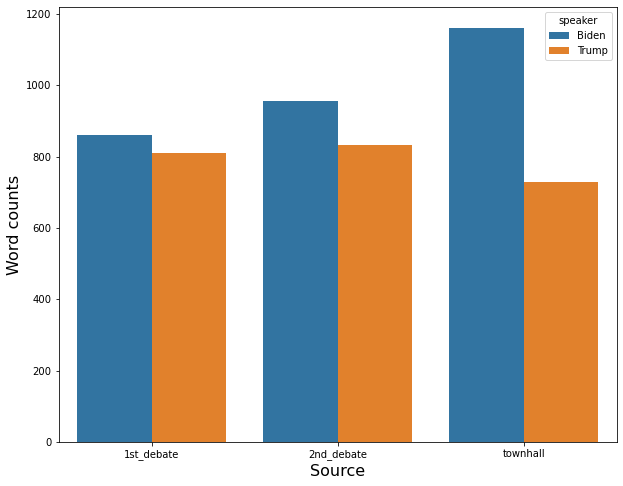

In [710]:
plt.figure(figsize = (10, 8))
sns.barplot(x = "source", y = "word_counts", hue = "speaker", data = words_count)
plt.xlabel("Source", fontsize = 16)
plt.ylabel("Word counts", fontsize = 16)
plt.show()

- Biden used 860 words in the first debate, 956 words in the second debate, and 1161 words in the town hall.
- Trump used 809 words in the first debate, 831 words in the second debate, and 728 words in the town hall.
- Trump used an almost similar number of words in every event.
- Biden used more words than trump in every event.

## 2. How many turns speaking did each candidate (Trump & Biden) take during each of the debates?

A "turn" is an uninterrupted period of speech.  For example, consider the following exchange:

>Chris: Big data is really interesting.

>Colleague: Actually, it's a bit boring.

>Chris: Really? Why would you say that?

>Colleague: Your choice of tools is really limited.

>Colleague: I mean, you're basically stuck with Spark, right?

>Chris: Yeah, but Spark provides most of the functionality you need to do really cool data science work.

In it, Chris had 3 turns, while his colleague had 2.

You answer should include a dataframe that looks like (with the real values instead of $__$:

<div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>First Debate</th>
      <th>Second Debate</th>
    </tr>
    <tr>
      <th>Candidate</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Trump</th>
      <td>__</td>
      <td>__</td>
    </tr>
    <tr>
      <th>Biden</th>
      <td>__</td>
      <td>__</td>
    </tr>
  </tbody>
</table>
</div>

In [714]:
txt_1st["before_speaker"] = txt_1st.speaker.shift()

txt_1st.loc[txt_1st.speaker != txt_1st.before_speaker, "is_turn"] = 1

first_debate_turn_count = pd.DataFrame(txt_1st.groupby("speaker").is_turn.sum() \
                              [["President Donald J. Trump", "Vice President Joe Biden"]]).rename(columns = {"is_turn" : "First Debate"})

first_debate_turn_count.index = ["Trump", "Biden"]

In [715]:
txt_2nd["before_speaker"] = txt_2nd.speaker.shift()

txt_2nd.loc[txt_2nd.speaker != txt_2nd.before_speaker, "is_turn"] = 1

second_debate_turn_count = pd.DataFrame(txt_2nd.groupby("speaker").is_turn.sum() \
                               [["Donald Trump", "Joe Biden"]]).rename(columns = {"is_turn" : "Second Debate"})

second_debate_turn_count.index = ["Trump", "Biden"]

In [716]:
debate_turn_count = pd.concat([first_debate_turn_count, second_debate_turn_count], axis = 1)

debate_turn_count.index.name = "Candidate"

debate_turn_count

,First Debate,Second Debate
Candidate,,
Trump,305.0,169.0
Biden,240.0,113.0


- In the first debate, Trump had 305 turns and Biden had 240 turns.
- In the second debate, Trump had 169 turns and Biden had 113 turns.
- In both debates, Trump had more turns than Biden.

## 3. How many different nouns did each candidate (Trump & Biden) use in each of the debates?  

Present your results using a visualization (hint: a simple bar chart, with one bar per candidate per debate would be a good choice; you should decide whether you want to somehow stack or group the bars in your bar chart, or just leave them all side by side). You do not need to report **which** nouns were used.  Provide a written interpretation of your visualization.

In [717]:
data = [("1st_debate", "Biden", np.sum(pd.DataFrame(txt_biden[txt_biden.source == "1st_debate"].text.str.split(expand = True).stack() \
                                .unique(), columns = ["word"]).word.apply(lambda x: [x.pos_ for x in nlp(x)]).str[0] == "NOUN")),
        ("1st_debate", "Trump", np.sum(pd.DataFrame(txt_trump[txt_trump.source == "1st_debate"].text.str.split(expand = True).stack() \
                                .unique(), columns = ["word"]).word.apply(lambda x: [x.pos_ for x in nlp(x)]).str[0] == "NOUN")),
        ("2nd_debate", "Biden", np.sum(pd.DataFrame(txt_biden[txt_biden.source == "2nd_debate"].text.str.split(expand = True).stack() \
                                .unique(), columns = ["word"]).word.apply(lambda x: [x.pos_ for x in nlp(x)]).str[0] == "NOUN")),
        ("2nd_debate", "Trump", np.sum(pd.DataFrame(txt_trump[txt_trump.source == "2nd_debate"].text.str.split(expand = True).stack() \
                                .unique(), columns = ["word"]).word.apply(lambda x: [x.pos_ for x in nlp(x)]).str[0] == "NOUN")),
        ("townhall", "Biden", np.sum(pd.DataFrame(txt_biden[txt_biden.source == "townhall"].text.str.split(expand = True).stack() \
                                .unique(), columns = ["word"]).word.apply(lambda x: [x.pos_ for x in nlp(x)]).str[0] == "NOUN")),
        ("townhall", "Trump", np.sum(pd.DataFrame(txt_trump[txt_trump.source == "townhall"].text.str.split(expand = True).stack() \
                                .unique(), columns = ["word"]).word.apply(lambda x: [x.pos_ for x in nlp(x)]).str[0] == "NOUN"))]

noun_counts = pd.DataFrame(data, columns = ["source", "speaker", "distinct_noun_counts"])

In [718]:
noun_counts

,source,speaker,distinct_noun_counts
0,1st_debate,Biden,360
1,1st_debate,Trump,316
2,2nd_debate,Biden,401
3,2nd_debate,Trump,333
4,townhall,Biden,481
5,townhall,Trump,285


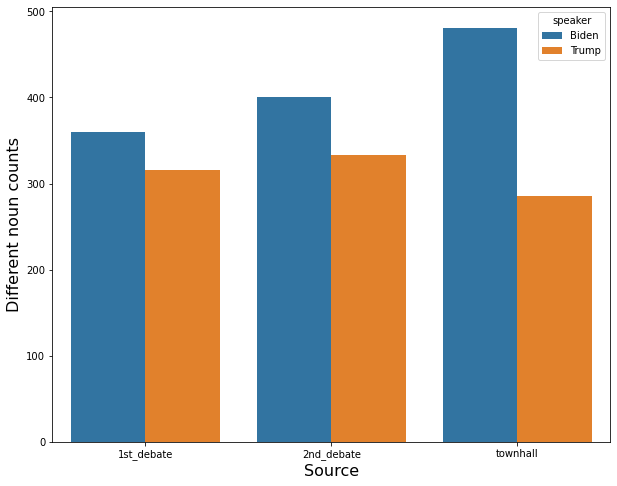

In [719]:
plt.figure(figsize = (10, 8))
sns.barplot(x = "source", y = "distinct_noun_counts", hue = "speaker", data = noun_counts)
plt.xlabel("Source", fontsize = 16)
plt.ylabel("Different noun counts", fontsize = 16)
plt.show()

- Biden used 360 different nouns in the first debate, 401 different nouns in the second debate, and 481 different nouns in the town hall.
- Trump used 316 different nouns in the first debate, 333 different nouns in the second debate, and 285 different nouns in the town hall.
- Trump used an almost similar number of different nouns in every event
- Biden used more different nouns than trump in every event.

## 4. Report the type-token ratio for each of the candidates (Trump & Biden), based on pooling the data from the two debates, and interpret the differences between the two candidates.

In text analysis, a 'type' is a unique word, whereas a 'token' is any word.  For example, the sentence

"One fish, two fish, red fish, blue fish"

contains 8 tokens, but 5 types (one, two, red, blue, fish).

Interestingly, the type-token ratio can be used to monitor changes in the use of vocabulary items in children with under-developed vocabulary and/or word finding difficulties and, for example, in adults who have suffered a stroke and who consequently exhibit word retrieval difficulties and naming difficulties. [Ref](https://www.sltinfo.com/type-token-ratio/)

In [720]:
data = [("Biden", 
         len(txt_biden[(txt_biden.source == "1st_debate") | (txt_biden.source == "2nd_debate")].text.str.split(expand = True).stack()),
         len(txt_biden[(txt_biden.source == "1st_debate") | (txt_biden.source == "2nd_debate")].text.str.split(expand = True).stack().unique())),
        ("Trump",
         len(txt_trump[(txt_trump.source == "1st_debate") | (txt_trump.source == "2nd_debate")].text.str.split(expand = True).stack()),
         len(txt_trump[(txt_trump.source == "1st_debate") | (txt_trump.source == "2nd_debate")].text.str.split(expand = True).stack().unique()))]

type_token_ratio = pd.DataFrame(data, columns = ["speaker", "num_of_token", "num_of_type"])

type_token_ratio["ratio"] = type_token_ratio.num_of_type / type_token_ratio.num_of_token

In [721]:
type_token_ratio

,speaker,num_of_token,num_of_type,ratio
0,Biden,5379,1346,0.250232
1,Trump,5702,1212,0.212557


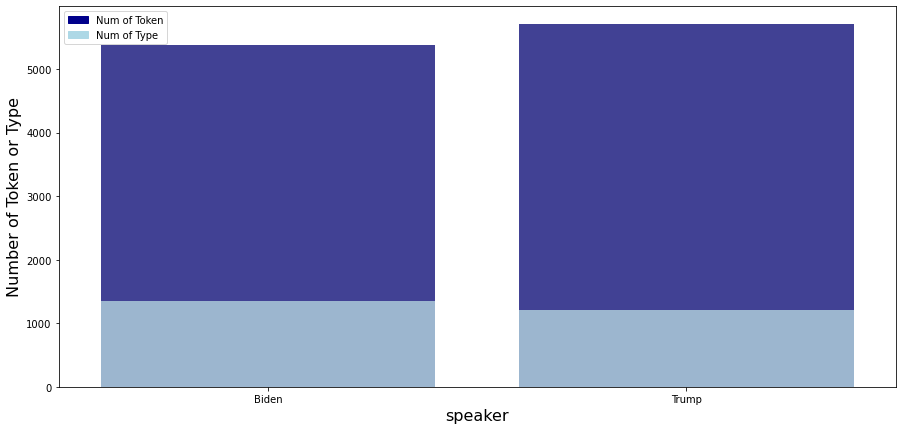

In [722]:
plt.figure(figsize = (15, 7))

# bar graph for token
color = "darkblue"
ax1 = sns.barplot(x = "speaker", y = "num_of_token", color = color, alpha = 0.8, \
                  data = type_token_ratio)
ax1.set_xlabel("Speaker", fontsize = 16)
top_bar = mpatches.Patch(color = color, label = 'Num of Token')

# bar graph for type
color = "lightblue"
ax2 = sns.barplot(x = "speaker", y = "num_of_type",  color = color, alpha = 0.8, \
                  data = type_token_ratio)
ax2.set_ylabel("Number of Token or Type", fontsize = 16)
low_bar = mpatches.Patch(color = color, label = 'Num of Type')

plt.legend(handles=[top_bar, low_bar])

plt.show()

- Trump's number of tokens is greater than Biden's number of tokens 
- But, Biden's number of types is greater than Trump's number of types 
- So, Biden's type-token ratio is 0.25, which is higher than Trump's type-token ratio of 0.21. That is, even though Trump used more words than Biden, there was more lexical variety in Biden's speech than Trump's speech.

## 5. Compare the use of named entities by the candidates (Trump & Biden) in their town hall meetings.  What patterns, if any, do you see?  

spaCy supports the following Named Entity types:
PERSON, NORP (nationalities, religious and political groups), FAC (buildings, airports etc.), ORG (organizations), GPE (countries, cities etc.), LOC (mountain ranges, water bodies etc.), PRODUCT (products), EVENT (event names), WORK_OF_ART (books, song titles), LAW (legal document titles), LANGUAGE (named languages), DATE, TIME, PERCENT, MONEY, QUANTITY, ORDINAL and CARDINAL.

You might want to use some visualization techniques to support your claims.

In [723]:
biden_label_count = pd.DataFrame(txt_biden[txt_biden.source == "townhall"].text.apply(lambda x: ' '.join([x.label_ for x in nlp(x).ents])) \
                                 .str.split(expand = True).stack().value_counts()).reset_index().rename(columns = {"index" : "named_entity_type", 0 : "count"})

biden_label_count["speaker"] = "Biden"
biden_label_count["description"] = biden_label_count.named_entity_type.apply(spacy.explain)
biden_label_count = biden_label_count[["speaker", "named_entity_type", "count", "description"]]

In [724]:
biden_label_count

,speaker,named_entity_type,count,description
0,Biden,CARDINAL,63,Numerals that do not fall under another type
1,Biden,PERSON,49,"People, including fictional"
2,Biden,NORP,27,Nationalities or religious or political groups
3,Biden,ORG,24,"Companies, agencies, institutions, etc."
4,Biden,GPE,23,"Countries, cities, states"
5,Biden,DATE,22,Absolute or relative dates or periods
6,Biden,MONEY,9,"Monetary values, including unit"
7,Biden,ORDINAL,5,"""first"", ""second"", etc."
8,Biden,PRODUCT,2,"Objects, vehicles, foods, etc. (not services)"
9,Biden,LAW,1,Named documents made into laws.


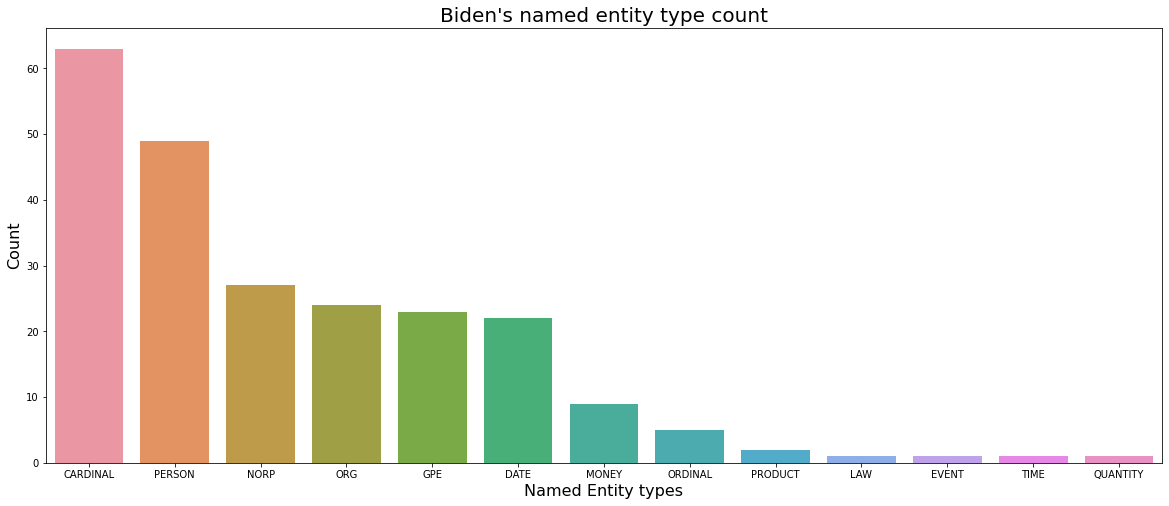

In [725]:
plt.figure(figsize = (20, 8))
sns.barplot(x = "named_entity_type", y = "count", data = biden_label_count)
plt.xlabel("Named Entity types", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Biden's named entity type count", fontsize = 20)
plt.show()

- Biden used a total of 13 types of named entity types.
- Among the named entity types used by Biden, the most common type is CARDINAL, followed by PERSON. 
- Types related to a specific group, such as NORP, ORG, and GPE, were the next most used, with about 25 times each.

In [726]:
trump_label_count = pd.DataFrame(txt_trump[txt_trump.source == "townhall"].text.apply(lambda x: ' '.join([x.label_ for x in nlp(x).ents])) \
                                 .str.split(expand = True).stack().value_counts()).reset_index().rename(columns = {"index" : "named_entity_type", 0 : "count"})

trump_label_count["speaker"] = "Trump"
trump_label_count["description"] = trump_label_count.named_entity_type.apply(spacy.explain)
trump_label_count = trump_label_count[["speaker", "named_entity_type", "count", "description"]]

In [727]:
trump_label_count

,speaker,named_entity_type,count,description
0,Trump,GPE,41,"Countries, cities, states"
1,Trump,CARDINAL,38,Numerals that do not fall under another type
2,Trump,PERSON,29,"People, including fictional"
3,Trump,DATE,22,Absolute or relative dates or periods
4,Trump,NORP,16,Nationalities or religious or political groups
5,Trump,ORG,15,"Companies, agencies, institutions, etc."
6,Trump,ORDINAL,3,"""first"", ""second"", etc."
7,Trump,LAW,3,Named documents made into laws.
8,Trump,MONEY,1,"Monetary values, including unit"
9,Trump,QUANTITY,1,"Measurements, as of weight or distance"


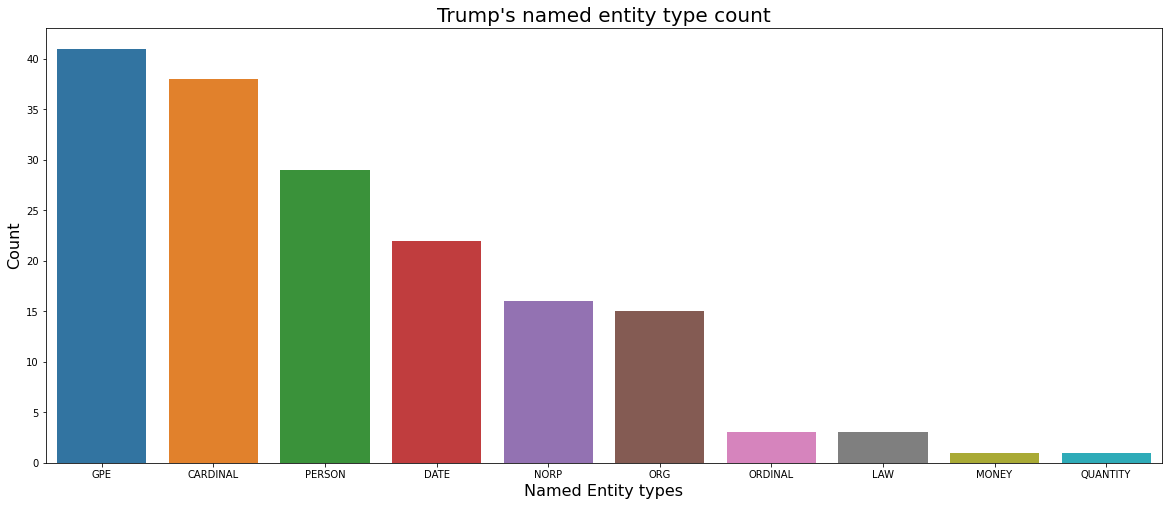

In [728]:
plt.figure(figsize = (20, 8))
sns.barplot(x = "named_entity_type", y = "count", data = trump_label_count)
plt.xlabel("Named Entity types", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Trump's named entity type count", fontsize = 20)
plt.show()

- Trump used a total of 10 types of named entity types.
- Among the named entity types used by Trump, the most common type is GPE, followed by CARDINAL. 
- Among types related to specific groups such as NORP, ORG, and GPE, Trump used the GPE types related to Countries, cities, and states the most with a total of 41 times. The NORP and ORG types were used about 15 times each, about half of GPE.

In [729]:
label_count = pd.concat([biden_label_count, trump_label_count])

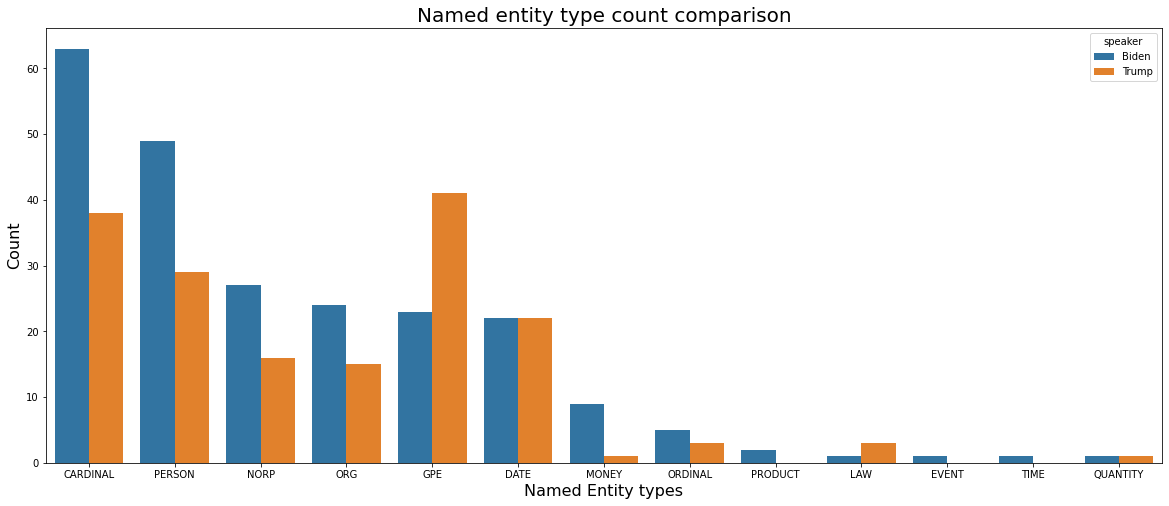

In [730]:
plt.figure(figsize = (20, 8))
sns.barplot(x = "named_entity_type", y = "count", hue = "speaker", data = label_count)
plt.xlabel("Named Entity types", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Named entity type count comparison", fontsize = 20)
plt.show()

- Biden used more various entity types than Trump.
- Biden used PERSON type words a lot, and Trump especially used GPE type words a lot, related to Countries, cities, and states.
- In all entity types except GPE and LAW, Biden used more or the same words than Trump.

## 6. Generate a word cloud for Trump's town hall (use only Trump's words) and one for Biden's town hall (again, use only Biden's words).  Compare and contrast the two word clouds.

Install a word cloud generating package like the one from https://github.com/amueller/word_cloud

In [731]:
biden_wordcloud = WordCloud().generate([" ".join([row for row in txt_biden[txt_biden.source == "townhall"].text.tolist()])][0])

In [732]:
trump_wordcloud = WordCloud().generate([" ".join([row for row in txt_trump[txt_trump.source == "townhall"].text.tolist()])][0])

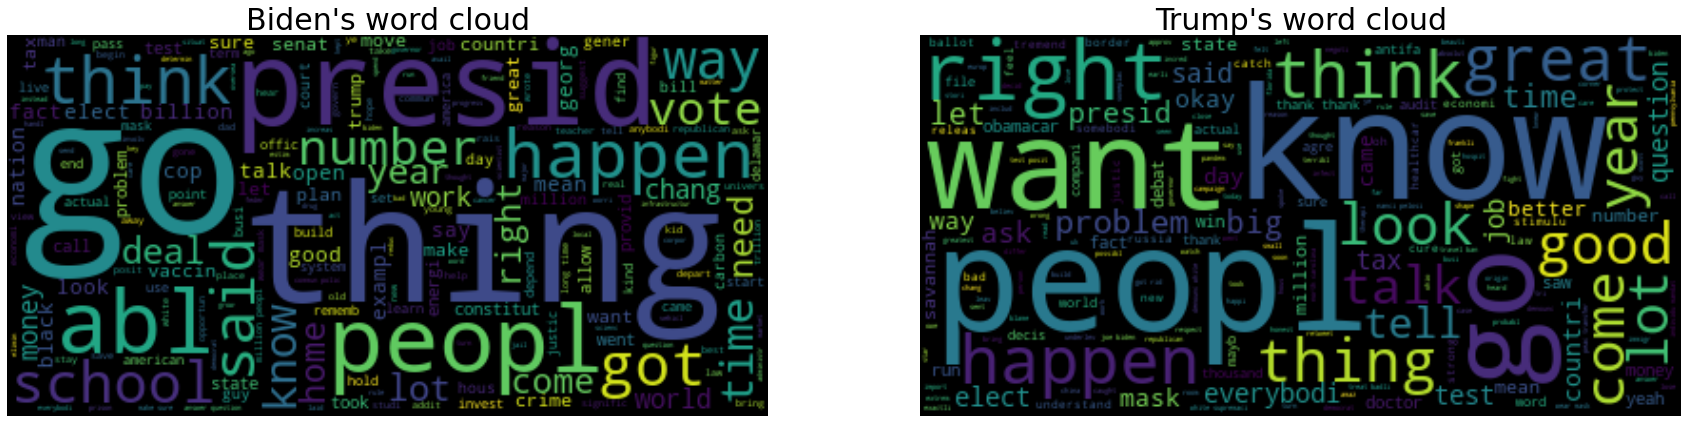

In [733]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30, 8))

# Biden's word cloud
ax1.imshow(biden_wordcloud, interpolation='bilinear')
ax1.set_title("Biden's word cloud", fontsize = 30)
ax1.axis("off")

# Trump's word cloud
ax2.imshow(trump_wordcloud, interpolation='bilinear')
ax2.set_title("Trump's word cloud", fontsize = 30)
ax2.axis("off")

plt.show()

- Looking at the two word clouds, it can be seen that go and peopl appeared a lot in both the words of Biden and Trump.
- In Biden's words, 'thing', 'presid', and 'abl' appeared a lot, and in Trump's words, 'know', 'want', and 'happen' appeared a lot.

## 7. Sentiment analysis of Trump vs. Biden in second debate

Note that you will want to review the video on Sentiment Analysis with NLTK and spaCy from the pre-recorded lectures.

Perform a sentiment analysis that compares the sentiment of the two candidates (Trump & Biden) in the second debate.  

There are several ways to do this.  In its simplest form, you could determine the sentiment for each utterance, the perform some mathematical summary (sum, mean, etc.) A slightly more elegant solution would involve tracking how sentiment changes over the course of the debate for each of the candidates.  A further extension of your work might use the [pandas.DataFrame.rolling()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html) method to calculate rolling averages, although using that function will probably require you to also learn about [time functions in pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html).

No matter what approach you choose, you should be sure to use visualizations in your answer.  As always, provide an interpretation of your results, including any visualizations (i.e. don't just provide a visualization, explain what's interesting that you see in your visualizations).

In [734]:
sent_analyzer = SentimentIntensityAnalyzer()

In [735]:
def sentiment_scores(docx):
    return sent_analyzer.polarity_scores(docx.text)

In [736]:
nlp = spacy.load('en_core_web_sm')

In [744]:
Doc.set_extension("sentimenter", getter = sentiment_scores, force = True)

In [745]:
# calculate rolling average of sentimental rate for Biden's 2nd debate

txt_2nd_biden["rating"] = txt_2nd_biden.text.apply(lambda x: nlp(x)._.sentimenter['compound'])

txt_2nd_biden['time_index'] = np.arange(1, txt_2nd_biden.shape[0] + 1)

txt_2nd_biden["rating_cumsum"] = txt_2nd_biden.rating.cumsum()

txt_2nd_biden["rating_rolling_average"] = txt_2nd_biden.rating_cumsum / txt_2nd_biden.time_index

txt_2nd_biden

,text,source,rating,time_index,rating_cumsum,rating_rolling_average
9,"220,000 Americans dead. You hear nothing else ...",2nd_debate,0.1518,1,0.1518,0.151800
10,"The expectation is we’ll have another 200,000 ...",2nd_debate,-0.5423,2,-0.3905,-0.195250
11,What I would do is make sure we have everyone ...,2nd_debate,0.8834,3,0.4929,0.164300
12,We’re in a situation now where the New England...,2nd_debate,-0.6449,4,-0.1520,-0.038000
20,Make sure it’s totally transparent. Have the s...,2nd_debate,-0.0516,5,-0.2036,-0.040720
...,...,...,...,...,...,...
495,"He takes everything out of context, but the po...",2nd_debate,0.3919,129,-0.8321,-0.006450
501,"No, I’m going to rejoin Paris Accord and make ...",2nd_debate,-0.0258,130,-0.8579,-0.006599
508,"I will say, I’m an American President. I repre...",2nd_debate,0.9001,131,0.0422,0.000322
509,"We can grow this economy, we can deal with the...",2nd_debate,0.9628,132,1.0050,0.007614


In [746]:
# calculate rolling average of sentimental rate for Trump's 2nd debate

txt_2nd_trump["rating"] = txt_2nd_trump.text.apply(lambda x: nlp(x)._.sentimenter['compound'])

txt_2nd_trump['time_index'] = np.arange(1, txt_2nd_trump.shape[0] + 1)

txt_2nd_trump["rating_cumsum"] = txt_2nd_trump.rating.cumsum()

txt_2nd_trump["rating_rolling_average"] = txt_2nd_trump.rating_cumsum / txt_2nd_trump.time_index

txt_2nd_trump

,text,source,rating,time_index,rating_cumsum,rating_rolling_average
1,How are you doing? How are you?,2nd_debate,0.0000,1,0.0000,0.000000
5,"So as you know, 2.2 million people modeled out...",2nd_debate,-0.9190,2,-0.9190,-0.459500
6,There was a very big spike in Texas. It’s now ...,2nd_debate,0.3612,3,-0.5578,-0.185933
7,"I can tell you from personal experience, I was...",2nd_debate,0.5574,4,-0.0004,-0.000100
14,"No, it’s not a guarantee, but it will be by th...",2nd_debate,0.6736,5,0.6732,0.134640
...,...,...,...,...,...,...
499,Is he going to get China to do it?,2nd_debate,0.0000,186,6.1531,0.033081
502,[Crosstalk 00:24:31].,2nd_debate,0.0000,187,6.1531,0.032904
504,We have to make our country totally successful...,2nd_debate,0.3708,188,6.5239,0.034702
505,"Before the plague came in, just before, I was ...",2nd_debate,0.6808,189,7.2047,0.038120


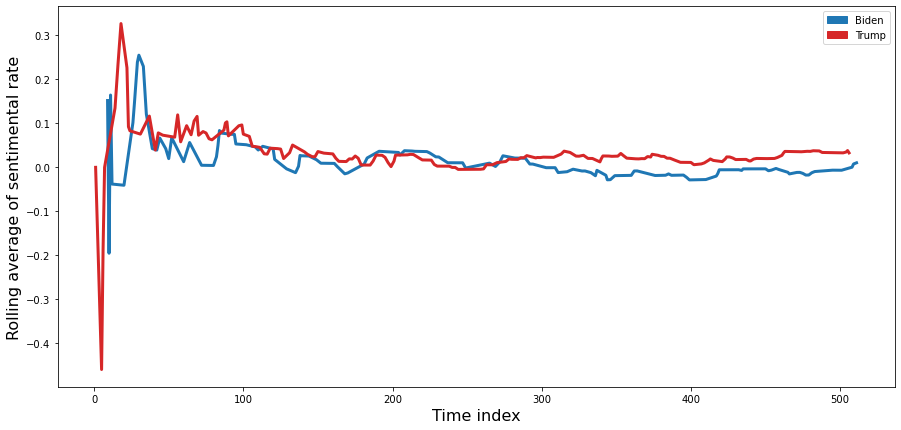

In [747]:
plt.figure(figsize = (15,7))

# line plot for Biden's rolling average of sentimental
color = "tab:blue"

sns.lineplot(data = txt_2nd_biden.rating_rolling_average, color = color, linewidth = 3)
blue_line = mpatches.Patch(color = color, label = 'Biden')

# line plot for Biden's rolling average of sentimental
color = "tab:red"

sns.lineplot(data = txt_2nd_trump.rating_rolling_average, color = color, linewidth = 3)
red_line = mpatches.Patch(color = color, label = 'Trump')

plt.legend(handles=[blue_line, red_line])
plt.xlabel("Time index", fontsize = 16)
plt.ylabel("Rolling average of sentimental rate", fontsize = 16)
plt.show()

- In both cases, the ups and downs of the sentimental rate are large at the beginning, and the ups and downs become smaller as time goes by.
- Trump's sentimental ups and downs are greater than Biden's.
- In general, Trump tends to have a higher average sentimental rate than Biden.

# Please submit your notebook in .IPYNB and .HTML formats

We **strongly** suggest running all cells from top to bottom before you submit your notebook.